# Regression case study with Bayesian Neural Networks

**Goal:** In this notebook you will investigate which advantages Bayesian NNs can offer in a regression task for a Normal Distributed CPD. First, you fit a "traditional" non-Bayesian NN and then you will fit two Bayesian NN, one via variational inference and one via MC-dropout. You will compare the results of the different models, especially you will have a look at the extrapolation case.

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it.

**Dataset:** 
A simulated dataset with a sine wave that has a small positive linear trend and a variance that depends on the amplitude.

**Content:**
* Simulate the data set
* Fit a non-Bayesian regression model yielding a single $\mu_x$ and $\sigma_x$ for a fixed value of $x$
* Fit a Bayesian regression model via variational inference yielding a distribution for $\mu_x$ and $\sigma_x$ 
* Fit a Bayesian regression model via dropout yielding a distribution for $\mu_x$ and $\sigma_x$
* Comparing the CPD of all three approaches


| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_08/nb_ch08_03.ipynb)

In [1]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

In [2]:
import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0  running in colab?:  False


#### Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
import urllib.request
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFP Version 0.8.0
TF  Version 2.0.0


In [5]:
def create_sine_data(n = 300):
    np.random.seed(32)
    n = 300
    x = np.linspace(0,1*2*np.pi,n)
    y1 = 3*np.sin(x)
    y1 = np.concatenate((np.zeros(60), y1+np.random.normal(0,0.15*np.abs(y1),n),np.zeros(60)))
    x=np.concatenate((np.linspace(-3,0,60),np.linspace(0,3*2*np.pi,n),np.linspace(3*2*np.pi,3*2*np.pi+3,60)))
    y2 = 0.1*x+1
    y=y1+y2
    return x,y

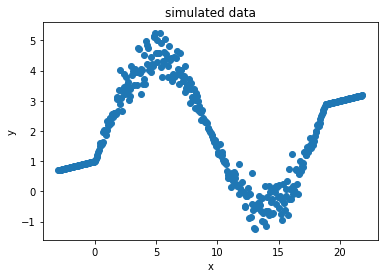

In [6]:
## use custom function to simulate some data 
x,y = create_sine_data(n=300) #A
plt.scatter(x=x,y=y,marker='o')
plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")
n=len(x)

## Non-Bayesian (just aleatoric)

We create a non-Bayesian model for the mean $\mu_x$ and the standard deviation $\sigma_x$

In [7]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def NLL(y, distr): 
  return -distr.log_prob(y) 

def normal_sp(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

inputs = Input(shape=(1,))
hidden = Dense(20,activation="relu")(inputs)
hidden = Dense(50,activation="relu")(hidden)
hidden = Dense(20,activation="relu")(hidden)
params = Dense(2)(hidden)
dist = tfp.layers.DistributionLambda(normal_sp)(params) 

model_aleatoric = Model(inputs=inputs, outputs=dist)
model_aleatoric.compile(Adam(), loss=NLL) 

In [8]:
model_aleatoric.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 20)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1050      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 42        
_________________________________________________________________
distribution_lambda (Distrib ((None, 1), (None, 1))    0         
Total params: 2,152
Trainable params: 2,152
Non-trainable params: 0
___________________________________________________________

In [9]:
#history = model_aleatoric.fit(x, y, epochs=5000, verbose=0,batch_size=32)
#plt.plot(history.history['loss'])
#plt.legend(['loss'])
#plt.ylabel('NLL')
#plt.xlabel('Epochs')
#plt.show()

In [10]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_aleatoric_weights.hdf5", "model_aleatoric_weights.hdf5")
model_aleatoric.load_weights("model_aleatoric_weights.hdf5")

In [11]:
model_aleatoric_mean = Model(inputs=inputs, outputs=dist.mean())
model_aleatoric_sd = Model(inputs=inputs, outputs=dist.stddev())

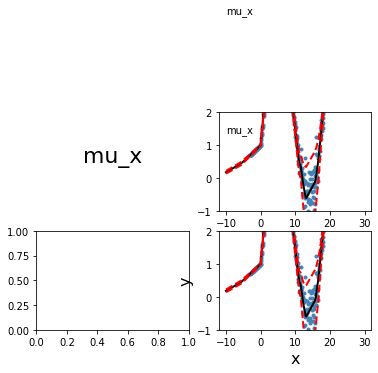

In [110]:
def make_no_bayes_plot(ax, text, model_mu, model_sig, add_std=False, stretch=1, alpha_data=1.0,ylim=[-1,2]):
    x_pred = np.arange(-10,30,0.1)
    ax.scatter(x,y,color="steelblue", alpha=alpha_data,marker='.') #observerd 
    mus_pred = model_mu.predict(x_pred)
    sig_pred = model_sig.predict(x_pred)
    ax.plot(x_pred,mus_pred * stretch,color="black",linewidth=2)
    if add_std:
        ax.plot(x_pred,mus_pred + 2 * sig_pred,color="red",linestyle="--",linewidth=2) 
        ax.plot(x_pred,mus_pred - 2 * sig_pred,color="red",linestyle="--",linewidth=2)
    ax.text(-10,5,text)
    ax.set_ylim(ylim)

f,ax = plt.subplots(2,2)
make_no_bayes_plot(ax[0,1],"mu_x", model_aleatoric_mean, model_aleatoric_sd, add_std=True)
ax[0,0].axis('off')
ax[0,0].text(0.5,0.5, "mu_x",fontsize=22,horizontalalignment='center')

make_no_bayes_plot(ax[1,1],r"mu_x", model_aleatoric_mean, model_aleatoric_sd, add_std=True)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.show()

## Bayesian Model using VI

In [24]:
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)


inputs = Input(shape=(1,))


hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(inputs)
hidden = tfp.layers.DenseFlipout(50,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
params = tfp.layers.DenseFlipout(2,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(hidden)
dist = tfp.layers.DistributionLambda(normal_sp)(params) 


model_vi = Model(inputs=inputs, outputs=dist)
model_vi.compile(Adam(), loss=NLL) 

Instructions for updating:
Please use `layer.add_weight` method instead.


In [25]:
model_vi.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 20)                80        
_________________________________________________________________
dense_flipout_1 (DenseFlipou (None, 50)                2100      
_________________________________________________________________
dense_flipout_2 (DenseFlipou (None, 20)                2040      
_________________________________________________________________
dense_flipout_3 (DenseFlipou (None, 2)                 84        
_________________________________________________________________
distribution_lambda_1 (Distr ((None, 1), (None, 1))    0         
Total params: 4,304
Trainable params: 4,304
Non-trainable params: 0
_________________________________________________________

In [26]:
# history = model_vi.fit(x, y, epochs=4000, verbose=0,batch_size=32)
# #around 10 min
# plt.plot(history.history['loss'])
# plt.legend(['loss'])
# plt.ylabel('NLL')
# plt.xlabel('Epochs')
# plt.ylim([0,20])
# plt.show()

In [27]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_aleatoric_epistemic_weights.hdf5", "model_aleatoric_epistemic_weights.hdf5")
model_vi.load_weights("model_aleatoric_epistemic_weights.hdf5")

model_vi_mean = Model(inputs=inputs, outputs=dist.mean())
model_vi_sd = Model(inputs=inputs, outputs=dist.stddev())

In [65]:
runs = 200

In [66]:
# Predicting the mu and sigma
x_pred = np.arange(-10,30,0.1)
vi_mus =np.zeros((runs,len(x_pred)))
vi_stds=np.zeros((runs,len(x_pred)))
for i in tqdm(range(0,runs)):
    vi_mus[i,:]=np.reshape(model_vi_mean.predict(x_pred),len(x_pred))
    vi_stds[i,:]=np.reshape(model_vi_sd.predict(x_pred),len(x_pred))

### Parameter $\mu_x$ for several runs 

We start several runs and plot the parameters $\mu_x$

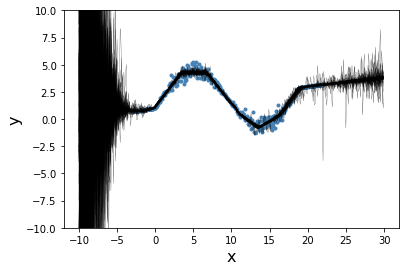

In [93]:
def make_bayes_plot_runs(ax, preds, runs = 100,alpha_data=1,ylim=[-7,8]):
    x_pred = np.arange(-10,30,0.1)
    ax.scatter(x,y,color="steelblue", alpha=alpha_data,marker='.') #observerd 
    for i in range(0,runs):
      ax.plot(x_pred, preds[i,0:400],color="black",linewidth=0.2)
    ax.set_ylim(ylim)
  
ax = plt.subplot()
make_bayes_plot_runs(ax, vi_mus)
plt.ylim([-10,10])
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.show()

#### Taking statistics of the different runs 

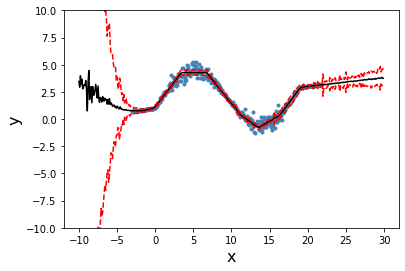

In [94]:
def make_bayes_plot_runs_avg(ax, preds, runs = 100,alpha_data=1,ylim=[-7,8]):
    x_pred = np.arange(-10,30,0.1)
    ax.scatter(x,y,color="steelblue", alpha=alpha_data,marker='.') #observerd      
    ax.set_ylim(ylim)
    ax.plot(x_pred,np.mean(preds,axis=0),color="black",linewidth=1.5)
    ax.plot(x_pred,np.mean(preds,axis=0)+2*np.std(preds,axis=0),color="red",linewidth=1.5,linestyle="--")
    ax.plot(x_pred,np.mean(preds,axis=0)-2*np.std(preds,axis=0),color="red",linewidth=1.5,linestyle="--")

ax = plt.subplot()
make_bayes_plot_runs_avg(ax,vi_mus)
plt.ylim([-10,10])
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.show()

## Modeling the CPD


In [32]:
x_pred = np.arange(-10,30,0.1)
vi_cpd =np.zeros((runs,len(x_pred)))
for i in tqdm(range(0,runs)):
    vi_cpd[i,:]=np.reshape(model_vi.predict(x_pred),len(x_pred))

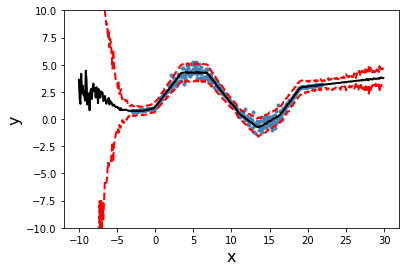

In [33]:
ax = plt.subplot()
make_bayes_plot_runs_avg(ax,vi_cpd)
plt.ylim([-10,10])
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.show()

## MC Dropout

In [34]:
def normal_exp(params): 
  return tfd.Normal(loc=params[:,0:1], scale=tf.math.exp(params[:,1:2]))# both parameters are learnable

In [35]:
from tensorflow.keras.layers import Dropout

inputs = Input(shape=(1,))
hidden = Dense(200,activation="relu")(inputs)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(200,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
params_mc = Dense(2)(hidden)
dist_mc = tfp.layers.DistributionLambda(normal_exp, name='normal_exp')(params_mc) 

model_mc = Model(inputs=inputs, outputs=dist_mc)
model_mc.compile(Adam(), loss=NLL) 

In [36]:
model_mc.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               400       
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 500)               100500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0   

In [37]:
#history = model_mc.fit(x, y, epochs=20000, verbose=0,batch_size=32)
#dauert ca 20min mit 20000 epochs

In [38]:
# plt.plot(history.history['loss'])
# plt.legend(['loss'])
# plt.ylabel('NLL')
# plt.xlabel('Epochs')
#model_mc.save_weights('model_mc_weights.hdf5')

In [39]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_mc_weights.hdf5", "model_mc_weights.hdf5")
model_mc.load_weights("model_mc_weights.hdf5")

In [40]:
model_mc_mean = Model(inputs=inputs, outputs=dist_mc.mean())
model_mc_sd = Model(inputs=inputs, outputs=dist_mc.stddev())

In [41]:
# Predicting the mu and sigma
mc_mus=np.zeros((runs,len(x_pred)))
mc_std=np.zeros((runs,len(x_pred)))
for i in tqdm(range(0,runs)):
  mc_mus[i,:]=np.reshape(model_mc_mean.predict(x_pred),len(x_pred))
  mc_std[i,:]=np.reshape(model_mc_sd.predict(x_pred),len(x_pred))

In [42]:
x_pred = np.arange(-10,30,0.1)
mc_cpd =np.zeros((runs,len(x_pred)))
for i in tqdm(range(0,runs)):
    mc_cpd[i,:]=np.reshape(model_mc.predict(x_pred),len(x_pred))

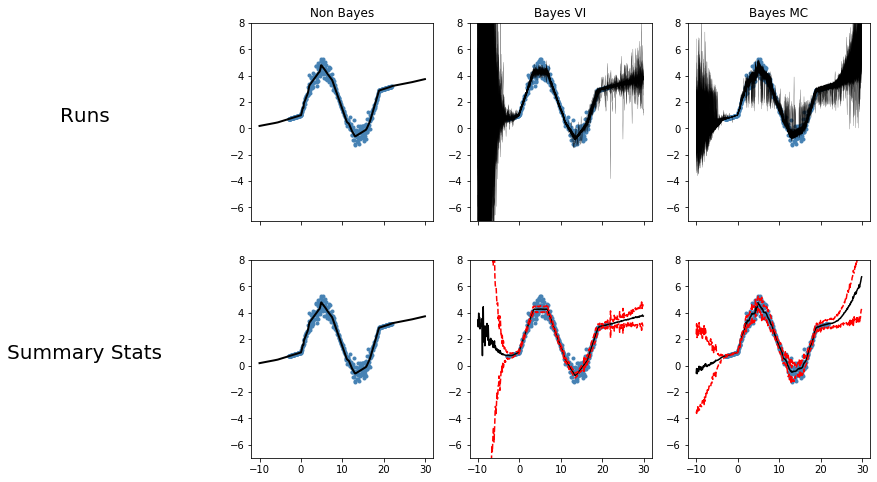

In [101]:
#plt.figure(figsize=(5,25))
f,ax = plt.subplots(2,4,sharex=True, sharey=False,figsize=(15,8))



make_no_bayes_plot(ax[0,1],"", model_aleatoric_mean, model_aleatoric_sd, add_std=False,ylim=[-7,8])
ax[0,1].set_title('Non Bayes')
make_no_bayes_plot(ax[1,1],"", model_aleatoric_mean, model_aleatoric_sd, add_std=False,ylim=[-7,8])


ax[0,2].set_title('Bayes VI')
make_bayes_plot_runs(ax[0,2], vi_mus, ylim=[-7,8])
make_bayes_plot_runs_avg(ax[1,2], vi_mus, ylim=[-7,8])

ax[0,3].set_title('Bayes MC')
make_bayes_plot_runs(ax[0,3], mc_mus, ylim=[-7,8])
make_bayes_plot_runs_avg(ax[1,3], mc_mus, ylim=[-7,8])

ax[0,0].axis('off')
ax[0,0].text(0.5,0.5, "Runs",fontsize=20,horizontalalignment='center')

ax[1,0].axis('off')
ax[1,0].text(0.5,0.5, "Summary Stats",fontsize=20,horizontalalignment='center')


plt.savefig('ch08_good_mu.pdf')

plt.show()

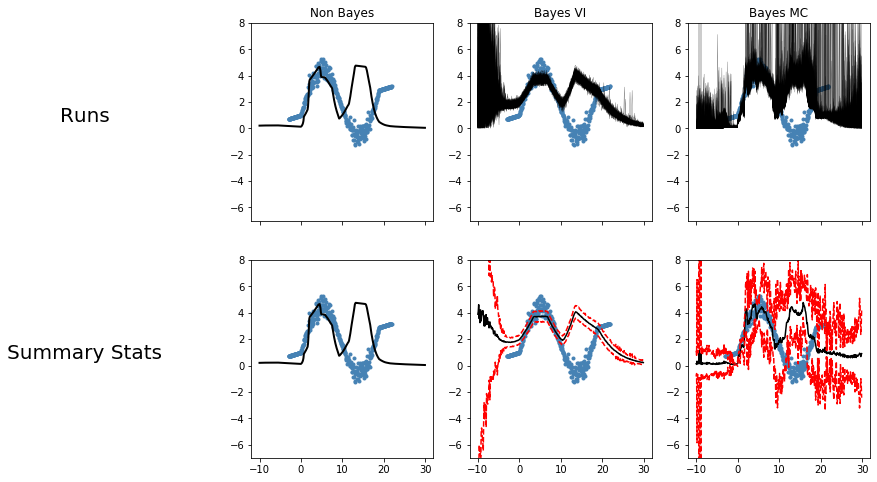

In [114]:
#plt.figure(figsize=(5,25))
f,ax = plt.subplots(2,4,sharex=True, sharey=False,figsize=(15,8))



make_no_bayes_plot(ax[0,1],"", model_aleatoric_sd, model_aleatoric_sd, add_std=False,ylim=[-7,8], stretch=10)
ax[0,1].set_title('Non Bayes')
make_no_bayes_plot(ax[1,1],"", model_aleatoric_sd, model_aleatoric_sd, add_std=False,ylim=[-7,8], stretch=10)


ax[0,2].set_title('Bayes VI')
make_bayes_plot_runs(ax[0,2], 10*vi_stds, ylim=[-7,8])
make_bayes_plot_runs_avg(ax[1,2], 10*vi_stds, ylim=[-7,8])

ax[0,3].set_title('Bayes MC')
make_bayes_plot_runs(ax[0,3], 10*mc_std, ylim=[-7,8])
make_bayes_plot_runs_avg(ax[1,3], 10*mc_std, ylim=[-7,8])

ax[0,0].axis('off')
ax[0,0].text(0.5,0.5, "Runs",fontsize=20,horizontalalignment='center')

ax[1,0].axis('off')
ax[1,0].text(0.5,0.5, "Summary Stats",fontsize=20,horizontalalignment='center')


plt.savefig('ch08_good_sig.pdf')

plt.show()